## Install required libraries

In [1]:
!pip install transformers
!pip install datasets
!pip install sentencepiece
!pip install rouge_score

     |████████████████████████████████| 2.3MB 2.9MB/s 
     |████████████████████████████████| 3.3MB 19.7MB/s 
     |████████████████████████████████| 901kB 30.2MB/s 
     |████████████████████████████████| 235kB 2.9MB/s 
     |████████████████████████████████| 245kB 12.5MB/s 
     |████████████████████████████████| 112kB 13.1MB/s 
     |████████████████████████████████| 1.2MB 2.9MB/s 


## Imports

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from datasets import load_dataset, load_metric
import datasets
import transformers
from transformers import T5Tokenizer
import matplotlib.pyplot as plt

## Load CNN / Daily Mail dataset

In [3]:
dataset = load_dataset('cnn_dailymail', '2.0.0')
dataset

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234. Subsequent calls will reuse this data.


DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

## Inspect data

In [4]:
type(dataset)

datasets.dataset_dict.DatasetDict

In [5]:
print(dataset['train'][0].keys())

dict_keys(['article', 'highlights', 'id'])


In [6]:
print(f"ARTICLE: {dataset['train'][0]['article']}\n")
print(f"HIGHLIGHTS: {dataset['train'][0]['highlights']}\n")
print(f"ID: {dataset['train'][0]['id']}")

ARTICLE: It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria. Obama sent a letter to the heads of the House and Senate on Saturday night, hours after announcing that he believes military action against Syrian targets is the right step to take over the alleged use of chemical weapons. The proposed legislation from Obama asks Congress to approve the use of military force "to deter, disrupt, prevent and degrade the potential for future uses of chemical weapons or other weapons of mass destruction." It's a step that is set to turn an international crisis into a fierce domestic political battle. There are key questions looming over the debate: What did U.N. weapons inspectors find in Syria? What happens if Congress votes no? And how will the Syrian government react? In a televised address from the White House Rose Garden earlier Saturday, the president said he would take his case to Congress, not because he has to -- but because h

## Filter very long / short examples

In [7]:
text_len = []
summary_len=[]
phase = ['train', 'validation', 'test']
long_summaries = []
long_articles = []
short_articles = []
short_summaries = []

for p in phase:
  for i in range(len(dataset[p])):
      example = dataset[p][i]
      article = example['article'].replace('\n','').split(" ")
      text_len.append(len(article))

      summary = example['highlights'].replace('\n','').split(" ")
      summary_len.append(len(summary))

      if len(article) < 150:
        short_articles.append(example)
      if len(article) > 512:
        long_articles.append(example)
      if len(summary) > 150:
        long_summaries.append(example)
      if len(summary) < 24:
        short_summaries.append(example)

## Dataset Statistics

In [8]:
print("Average Length of text: ", sum(text_len)/len(text_len))
print("Average Length of Summary: ", sum(summary_len)/len(summary_len))

Average Length of text:  690.8951505107847
Average Length of Summary:  49.08601761061124


In [9]:
print("Max Length of text: ", max(text_len))
print("Max Length of Summary: ", max(summary_len))

Max Length of text:  2347
Max Length of Summary:  1408


In [10]:
print("Min Length of text: ", min(text_len))
print("Min Length of Summary: ", min(summary_len))

Min Length of text:  8
Min Length of Summary:  4


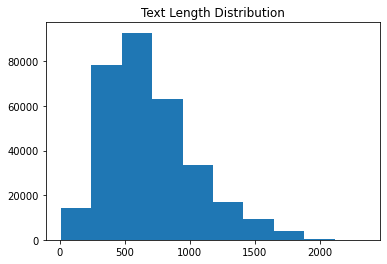

In [11]:
%matplotlib inline
plt.hist(text_len)
plt.title('Text Length Distribution')
plt.show()

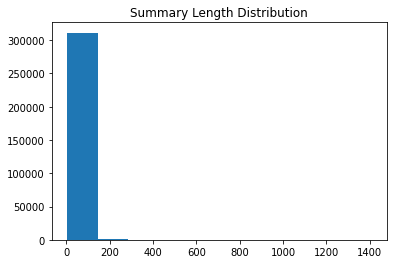

In [12]:
plt.hist(summary_len)
plt.title('Summary Length Distribution')
plt.show()

## Split train/val/test with filtered data

In [13]:
phase = ['train', 'validation', 'test']
for p in phase:
  if p == 'train':
   train_set = [e for e in dataset[p] if len(e['article'].split(" ")) >= 150 \
                and len(e['article'].split(" ")) <= 1024 \
                and len(e['highlights'].split(" ")) >= 15 \
                and len(e['highlights'].split(" ")) <= 250]
  if p == 'validation':
   val_set = [e for e in dataset[p] if len(e['article'].split(" ")) >= 150 \
              and len(e['article'].split(" ")) <= 1024 \
              and len(e['highlights'].split(" ")) >= 15 \
              and len(e['highlights'].split(" ")) <= 250]
  if p == 'test':
   test_set = [e for e in dataset[p] if len(e['article'].split(" ")) >= 150 \
               and len(e['article'].split(" ")) <= 1024 \
               and len(e['highlights'].split(" ")) >= 15 \
               and len(e['highlights'].split(" ")) <= 250]


In [14]:
print(f'train: {len(train_set)}\nval: {len(val_set)}\ntest: {len(test_set)}\n')

train: 237714
val: 11188
test: 9532



## Construct a full torch dataset from data

In [15]:
class cnn_dailymail(Dataset):
    def __init__(self, tokenizer, type_path, input_length, output_length, test_run=False):
        raw_dataset =  load_dataset('cnn_dailymail', '2.0.0')
        self.dataset = raw_dataset[type_path]

        self.input_length = input_length
        self.tokenizer = tokenizer
        self.output_length = output_length
        self.article_min_len = 150
        self.summary_min_len = 15

        self.clean_examples = self.filter_data()
        self.dataset = Subset(self.dataset, self.clean_examples)

        if test_run == True:
          self.dataset = Subset(self.dataset, np.arange(1000))
    
    def filter_data(self):
        clean_examples = []
        for i, e in enumerate(self.dataset):
          if len(e['article'].split(" ")) >= self.article_min_len \
           and len(e['article'].split(" ")) <= self.input_length \
           and len(e['highlights'].split(" ")) >= self.summary_min_len \
           and len(e['highlights'].split(" ")) <= self.output_length:
            clean_examples.append(i)
          else:
            continue
        return clean_examples

      
    def __len__(self):
        #return self.dataset.shape[0]
        return len(self.dataset)
    
    def clean_text(self, text):
        text = text.replace('\n','')
        text = text.replace('``', '')
        text = text.replace('"', '')
        
        return text
    
    
    def convert_to_features(self, example_batch):
        # Tokenize contexts and questions (as pairs of inputs)
        
        input_ = self.clean_text(example_batch['article'])
        target_ = self.clean_text(example_batch['highlights'])
        
        source = self.tokenizer.batch_encode_plus([input_], max_length=self.input_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
        
        targets = self.tokenizer.batch_encode_plus([target_], max_length=self.output_length, 
                                                     padding='max_length', truncation=True, return_tensors="pt")
    
       
        return source, targets
  
    def __getitem__(self, index):
        source, targets = self.convert_to_features(self.dataset[index])
        
        source_ids = source["input_ids"].squeeze()
        target_ids = targets["input_ids"].squeeze()

        src_mask    = source["attention_mask"].squeeze()
        target_mask = targets["attention_mask"].squeeze()

        return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}

## Initialize train/val/test datasets

In [16]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

train_dataset = cnn_dailymail(tokenizer, 'train', 1024, 250)
val_dataset = cnn_dailymail(tokenizer, 'validation', 1024, 250)
test_dataset = cnn_dailymail(tokenizer, 'test', 1024, 250)

Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)
Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)
Reusing dataset cnn_dailymail (/root/.cache/huggingface/datasets/cnn_dailymail/2.0.0/2.0.0/3cb851bf7cf5826e45d49db2863f627cba583cbc32342df7349dfe6c38060234)


## Inspect dataset

In [17]:
print(len(train_dataset.dataset))
print(len(val_dataset.dataset))
print(len(test_dataset.dataset))

237714
11188
9532


In [18]:
train_dataset.dataset[0]

{'article': '(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men\'s 4x100m relay. The fastest man in the world charged clear of United States rival Justin Gatlin as the Jamaican quartet of Nesta Carter, Kemar Bailey-Cole, Nickel Ashmeade and Bolt won in 37.36 seconds. The U.S finished second in 37.56 seconds with Canada taking the bronze after Britain were disqualified for a faulty handover. The 26-year-old Bolt has now collected eight gold medals at world championships, equaling the record held by American trio Carl Lewis, Michael Johnson and Allyson Felix, not to mention the small matter of six Olympic titles. The relay triumph followed individual successes in the 100 and 200 meters in the Russian capital. "I\'m proud of myself and I\'ll continue to work to dominate for as long as possible," Bolt said, having previously expressed his intention to carry on until the 2016 Rio Olympics. Victory 

## Load a single item from dataset

In [19]:
example = train_dataset.__getitem__(0)
example

{'source_ids': tensor([   41,   254, 17235,  ...,     0,     0,     0]),
 'source_mask': tensor([1, 1, 1,  ..., 0, 0, 0]),
 'target_ids': tensor([ 6952,     9,    77,  8166,    17,  9204,  1025,  2045,    13,   296,
         10183,     3,     5,   188,    29, 19220,     7, 21450,    12,   314,
           226,  2915,    51, 16010,  6224,     3,     5,   427,  2632,   107,
          2045,    44,     8, 10183,     7,    21,  8166,    17,     3,     5,
           683,   265,     9,  2617,  1486,    95,    16,   887,    31,     7,
           314,   226,  2915,    51, 16010,     3,     5,     1,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,  

In [20]:
example['source_ids'].shape

torch.Size([1024])

In [21]:
example['target_ids'].shape

torch.Size([250])